# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

Дата выдачи: 06.12.2021

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
x = load_npz('/content/drive/MyDrive/Машинное обучение (домашки Маши Тимониной)/ДЗ 7 Градиентный бустинг/x.npz')
y = np.load('/content/drive/MyDrive/Машинное обучение (домашки Маши Тимониной)/ДЗ 7 Градиентный бустинг/y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
% load_ext autoreload

In [ ]:
% autoreload 2

# from boosting import Boosting
from collections import defaultdict

import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = True,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = \
            {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        self.history = defaultdict(list)
        self.n_features: int = 0

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        self.loss_derivative2 = lambda y, z: \
         y ** 2 * self.sigmoid(-y * z) * (1 - self.sigmoid(-y * z))

    def fit_new_base_model(self, x, y, predictions):
        bm = self.base_model_class(**self.base_model_params)
        new_bm = bm.fit(x, - self.loss_derivative(y, predictions))

        g = self.find_optimal_gamma(y, predictions, new_bm.predict(x))
        self.gammas.append(g)
        self.models.append(new_bm)

    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        :param x_train: features array (train set)
        :param y_train: targets array (train set)
        :param x_valid: features array (validation set)
        :param y_valid: targets array (validation set)
        """
        trsize = y_train.shape[0]
        train_predictions = np.zeros(y_train.shape[0])
        valid_predictions = np.zeros(y_valid.shape[0])
        fails = 0
        self.n_features = x_train.shape[1]

        train_errors = np.zeros(self.n_estimators)
        valid_errors = np.zeros(self.n_estimators)
        for nm in range(self.n_estimators):
            # нужно обучить на бутстрепной подвыборке
            boot = np.random.choice(trsize, int(self.subsample * trsize))
            self.fit_new_base_model(x_train[boot],
                                    y_train[boot],
                                    train_predictions[boot])
            train_last_pred = self.models[-1].predict(x_train)
            train_predictions += self.learning_rate * self.gammas[-1] * train_last_pred
            
            valid_last_pred = self.models[-1].predict(x_valid)
            valid_predictions += self.learning_rate * self.gammas[-1] * valid_last_pred

            train_errors[nm] = self.loss_fn(y_train, train_predictions)
            valid_errors[nm] = self.loss_fn(y_valid, valid_predictions)
            
            fails = fails + 1 if (nm > 0 and valid_errors[-1] >= valid_errors[-2]) else 0
            if self.early_stopping_rounds is not None:
                if self.early_stopping_rouds <= fails:
                  break
        

        if self.plot:
            fig, ax = plt.subplots(figsize=[8, 5])
            ax.plot(range(1, nm + 1), train_errors[:nm], label='train')
            ax.plot(range(1, nm + 1), valid_errors[:nm], label='valid')
            ax.set_title("Error dependence on the estimators number")
            ax.set_xlabel("n_estimators")
            ax.set_ylabel("error")
            ax.legend()

            plt.show()
        return self

    def predict_proba(self, x):
        probs = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            probs += self.learning_rate * gamma * model.predict(x)
        ans = [1 - self.sigmoid(probs), self.sigmoid(probs)]
        return np.stack(ans, 1)

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) \
                                                              for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
        ans = np.zeros(self.n_features)
        for m in self.models:
            ans += m.feature_importances_
        return ans / np.sum(ans)


### Проверка кода

У автора задания всё учится около одной секунды.

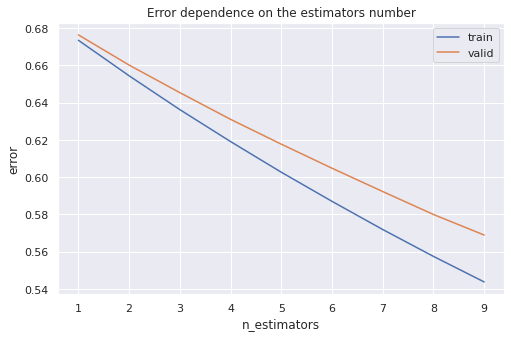

CPU times: user 1.97 s, sys: 0 ns, total: 1.97 s
Wall time: 1.98 s
Train ROC-AUC 0.9889
Valid ROC-AUC 0.9124
Test ROC-AUC 0.9136


In [ ]:
boosting = Boosting()

% time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
from tqdm import tqdm

results = {}
max_depths = range(1, 30, 2)

train_errors = np.zeros(15)
test_errors = np.zeros(15)

for ind, depth in tqdm(enumerate(max_depths)):
    boost = Boosting(base_model_params={"max_depth" : depth}, plot=False)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

15it [00:16,  1.07s/it]


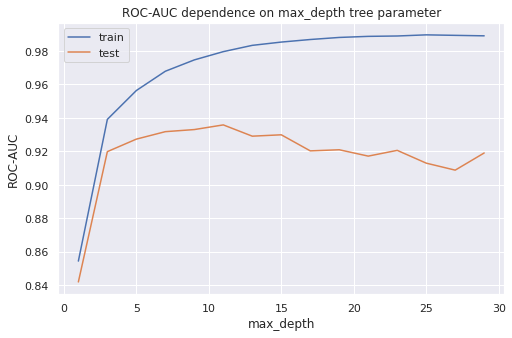

In [ ]:
fig, ax = plt.subplots(figsize=[8, 5])
ax.plot(max_depths, train_errors, label='train')
ax.plot(max_depths, test_errors, label='test')
ax.set_title("ROC-AUC dependence on max_depth tree parameter")
ax.set_xlabel("max_depth")
ax.set_ylabel("ROC-AUC")
ax.legend()

plt.show()

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Слишком короткие деревья могут быть недостаточно сложными, чтобы описать истинную зависимости в данных (даже если их много, целый ансамбль). Но совсем глубокие деревья уже переобучаются под выборку и хуже отражают общую картину.

В градиентном бустинге смещение падает с ростом количества деревьев, а разброс растет, поэтому нужны базовые мдели с может быть высоким сдвигом и низких разбросом.

In [ ]:
best_depth = max_depths[np.argmax(test_errors)]
best_depth

11

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

In [ ]:
def draw(samples, train_errors, test_errors, param):
    fig, ax = plt.subplots(figsize=[8, 5])
    ax.plot(samples, train_errors, label='train')
    ax.plot(samples, test_errors, label='test')
    ax.set_title(f"ROC-AUC dependence on {param} tree parameter")
    ax.set_xlabel(param)
    ax.set_ylabel("ROC-AUC")
    ax.legend()

    plt.show()

In [ ]:
param_dict = {"max_depth" : best_depth}

#### __min_samples_split__

8it [00:09,  1.14s/it]


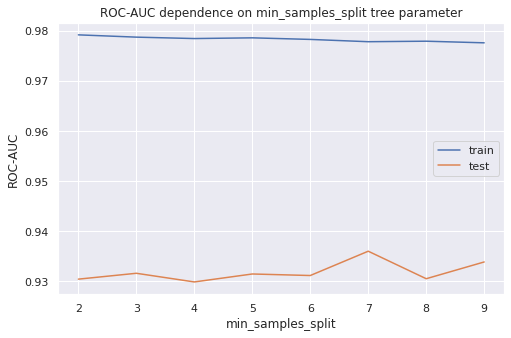

In [ ]:
min_samples_split = range(2, 10, 1)
parameter = min_samples_split
parname = "min_samples_split"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    param[parname] = num
    boost = Boosting(plot=False,
                     base_model_params=param)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
best = min_samples_split[np.argmax(test_errors)]
param_dict["min_samples_split"] = best
param_dict

{'max_depth': 11, 'min_samples_split': 7}

#### __min_samples_leaf__

6it [00:05,  1.09it/s]


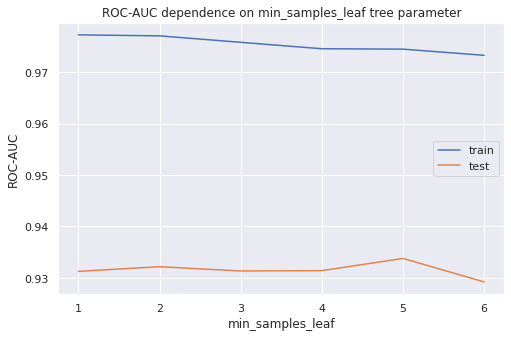

In [ ]:
min_samples_leaf = range(1, 7)
parameter = min_samples_leaf
parname = "min_samples_leaf"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    param[parname] = num
    boost = Boosting(plot=False,
                     base_model_params=param)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
best = parameter[np.argmax(test_errors)]
param_dict[parname] = best
param_dict

{'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 7}

#### __max_feature__

In [ ]:
x.shape[1]

169

34it [00:27,  1.26it/s]


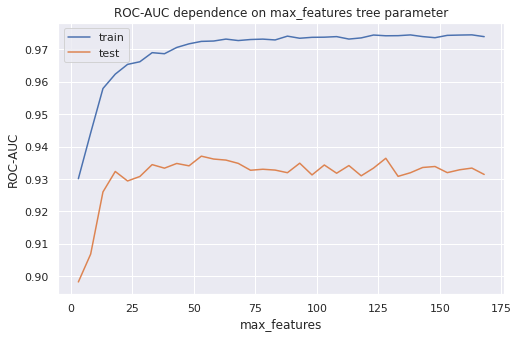

In [ ]:
max_feature = range(3, x.shape[1], 5)
parameter = max_feature
parname = "max_features"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    param[parname] = num
    boost = Boosting(plot=False,
                     base_model_params=param)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
# в случае max_features значение параметра непосредственно влияет а скорость
# а изменение качестве выходит на константу, ставить больше 50-70 не следует

best = parameter[np.argmax(test_errors)]
param_dict[parname] = best
param_dict

{'max_depth': 11,
 'max_features': 53,
 'min_samples_leaf': 5,
 'min_samples_split': 7}

#### __n_estimators__

13it [00:25,  1.92s/it]


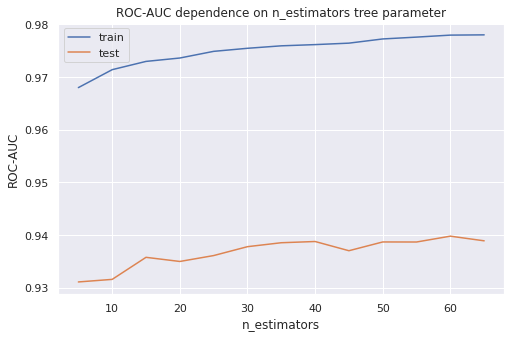

In [ ]:
n_estimators = range(5, 70, 5)
parameter = n_estimators
parname = "n_estimators"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    boost = Boosting(plot=False,
                     base_model_params=param,
                     n_estimators=num)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
n_estim = parameter[np.argmax(test_errors)]
n_estim

60

#### __learning rate__

24it [01:31,  3.83s/it]


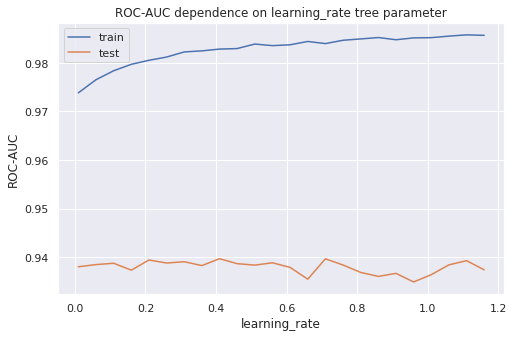

In [ ]:
lr = np.arange(0.01, 0.95, 0.05)
parameter = lr
parname = "learning_rate"

count = parameter.shape[0]
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    boost = Boosting(plot=False,
                     base_model_params=param,
                     n_estimators=n_estim,
                     learning_rate=num)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
lr_best = parameter[np.argmax(test_errors)]
lr_best

0.41000000000000003

#### __subsamples__

15it [01:47,  7.13s/it]


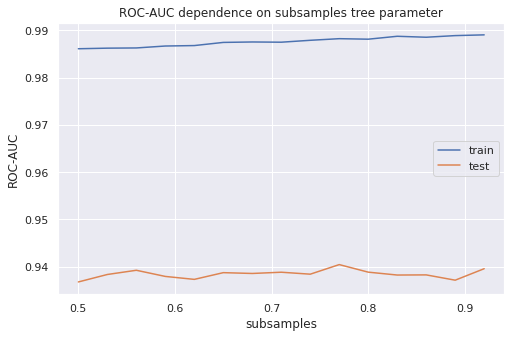

In [ ]:
subsamples = np.arange(0.5, 0.95, 0.03)
parameter = subsamples
parname = "subsamples"

count = parameter.shape[0]
train_errors = np.zeros(count)
test_errors = np.zeros(count)

param = param_dict.copy()
for ind, num in tqdm(enumerate(parameter)):
    boost = Boosting(plot=False,
                     base_model_params=param,
                     n_estimators=n_estim,
                     learning_rate=lr_best,
                     subsample=num)
    boost.fit(x_train, y_train, x_valid, y_valid)

    train_errors[ind] = boost.score(x_train, y_train)
    test_errors[ind] = boost.score(x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
sub_best = parameter[np.argmax(test_errors)]
sub_best

0.7700000000000002

#### __Final model__

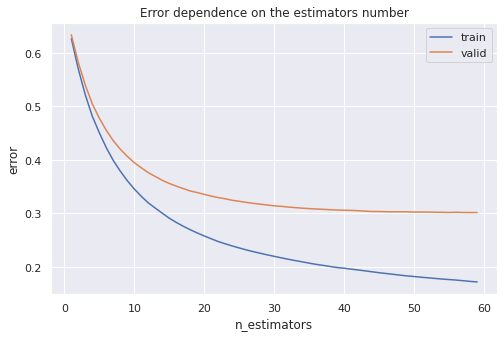

Best ROC_AUC on train:  0.9880677634629235
Best ROC_AUC on test:  0.9391102195952594


In [ ]:
boost = Boosting(
    base_model_params=param,
    n_estimators=n_estim,
    learning_rate=lr_best,
    subsample=sub_best)
boost.fit(x_train, y_train, x_valid, y_valid)

print('Best ROC_AUC on train: ', boost.score(x_train, y_train))
print('Best ROC_AUC on test: ', boost.score(x_test, y_test))

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [ ]:
# !pip install catboost

In [ ]:
from catboost import CatBoostClassifier

Попробовала в том же порядке (понятно, что это имеет значение) подбирать параметры, но качественный бустинг учится уже заметно дольше, чем кастомный!

#### __iterations(n_estimators)__

20it [00:35,  1.77s/it]


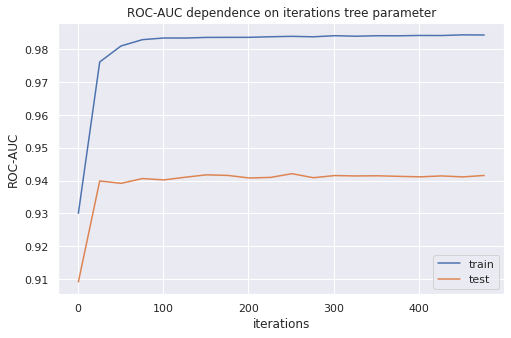

In [ ]:
iterations = np.arange(1, 500, 25)
parameter = iterations
parname = "iterations"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

for ind, num in tqdm(enumerate(parameter)):
    boost = CatBoostClassifier(iterations=num)
    boost.fit(x_train, y_train, logging_level='Silent')

    train_errors[ind] = score(boost, x_train, y_train)
    test_errors[ind] = score(boost, x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

Оказывается, много моделей и не нужно - качеству это существенно не помогает дальше.

9it [00:03,  2.32it/s]


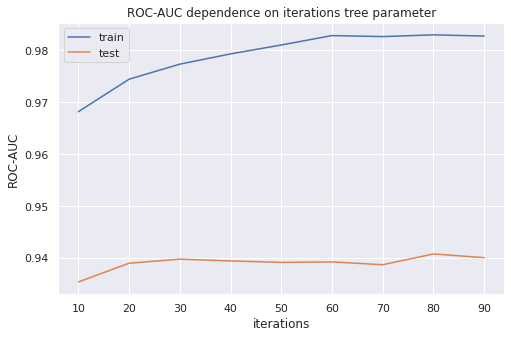

In [ ]:
iterations = np.arange(10, 100, 10)
parameter = iterations
parname = "iterations"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

for ind, num in tqdm(enumerate(parameter)):
    boost = CatBoostClassifier(iterations=num)
    boost.fit(x_train, y_train, logging_level='Silent')

    train_errors[ind] = score(boost, x_train, y_train)
    test_errors[ind] = score(boost, x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
n_estim_catboost = 80

#### __max_depth__

6it [00:11,  1.86s/it]


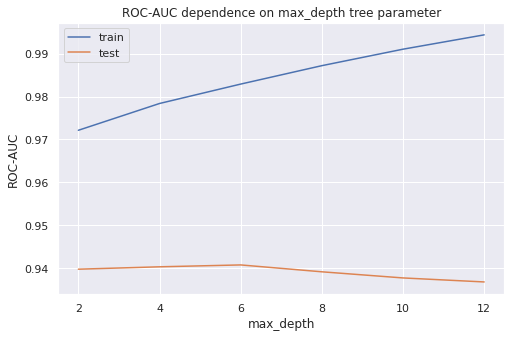

In [ ]:
max_depth = range(2, 13, 2)
parameter = max_depth
parname = "max_depth"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

for ind, num in tqdm(enumerate(parameter)):
    boost = CatBoostClassifier(iterations=80,
                               depth=num)
    boost.fit(x_train, y_train, logging_level='Silent')

    train_errors[ind] = score(boost, x_train, y_train)
    test_errors[ind] = score(boost, x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
max_depth_catboost = 6

#### __learning rate__

19it [00:13,  1.40it/s]


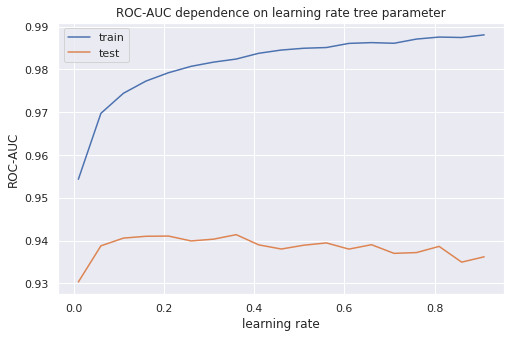

In [ ]:
lr = np.arange(0.01, 0.95, 0.05)
parameter = lr
parname = "learning rate"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

for ind, num in tqdm(enumerate(parameter)):
    boost = CatBoostClassifier(iterations=80,
                               depth=6,
                               learning_rate=num)
    boost.fit(x_train, y_train, logging_level='Silent')

    train_errors[ind] = score(boost, x_train, y_train)
    test_errors[ind] = score(boost, x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

In [ ]:
lr_best_catboost = parameter[np.argmax(test_errors)]
lr_best_catboost

0.36000000000000004

#### __subsamples__

15it [00:10,  1.39it/s]


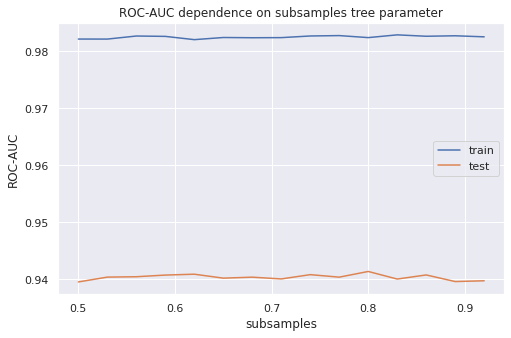

In [ ]:
subsamples = np.arange(0.5, 0.95, 0.03)
parameter = subsamples
parname = "subsamples"

count = len(parameter)
train_errors = np.zeros(count)
test_errors = np.zeros(count)

for ind, num in tqdm(enumerate(parameter)):
    boost = CatBoostClassifier(iterations=80,
                               depth=6,
                               learning_rate=lr_best_catboost,
                               subsample=num)
    boost.fit(x_train, y_train, logging_level='Silent')

    train_errors[ind] = score(boost, x_train, y_train)
    test_errors[ind] = score(boost, x_test, y_test)

draw(parameter, train_errors, test_errors, parname)

Не полезный параметр получился:/ Пусть тогда сам его определяет

#### __Final model__

In [ ]:
boost = Boosting(plot=False,
    base_model_params=param,
    n_estimators=n_estim,
    learning_rate=lr_best,
    subsample=sub_best)
boost.fit(x_train, y_train, x_valid, y_valid)

catboost = CatBoostClassifier(iterations=80,
                               depth=6,
                               learning_rate=lr_best_catboost,
                               subsample=num)
catboost.fit(x_train, y_train, logging_level='Silent')

print('Best ROC_AUC on train custom: ', boost.score(x_train, y_train))
print('Best ROC_AUC on train catboost: ', score(catboost, x_train, y_train))
print("\nTest!")
print('Best ROC_AUC on test custom: ', boost.score(x_test, y_test))
print('Best ROC_AUC on test catboost: ', score(catboost, x_test, y_test))

Best ROC_AUC on train custom:  0.9883132109573004
Best ROC_AUC on train catboost:  0.9825687170461082

Test!
Best ROC_AUC on test custom:  0.9391452521794991
Best ROC_AUC on test catboost:  0.939738050739778


На тесте CatBoost победил при том, что под трейн успел подстроиться меньше.

In [ ]:
catboost = CatBoostClassifier()
catboost.fit(x_train, y_train, logging_level='Silent')

print('Best ROC_AUC on train Simple catboost: ', score(catboost, x_train, y_train))
print("\nTest!")
print('Best ROC_AUC on test Simple catboost: ', score(catboost, x_test, y_test))

Best ROC_AUC on train Simple catboost:  0.984845035007571

Test!
Best ROC_AUC on test Simple catboost:  0.9416219377978754


Сам он подбирает параметры лучше, чуть-чуть. Можно кол-во моделей не ограничивать.

In [ ]:
catboost = CatBoostClassifier(depth=6,
                               learning_rate=lr_best_catboost,
                               subsample=num)
catboost.fit(x_train, y_train, logging_level='Silent')

print('Best ROC_AUC on train catboost: ', score(catboost, x_train, y_train))
print("\nTest!")
print('Best ROC_AUC on test catboost: ', score(catboost, x_test, y_test))

Best ROC_AUC on train catboost:  0.9962372721656187

Test!
Best ROC_AUC on test catboost:  0.9370661273485609


Стало похуже, переобучился!

### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [ ]:
# !pip install optuna

In [ ]:
import optuna

optuna.logging.disable_propagation()
optuna.logging.disable_default_handler()

def pipeline(trial):
  n_estimators = trial.suggest_int('n_estimators', 5, 200)
  
  depth = trial.suggest_int('max_depth', 2, 10)
  subsample = trial.suggest_uniform('subsample', 0.1, 1)
  lr = trial.suggest_uniform('learning_rate', 0.001, 1)

  catboost = CatBoostClassifier(iterations=n_estimators, 
                                 learning_rate=lr, 
                                 depth=depth, 
                                 subsample=subsample, 
                                 logging_level="Silent")
  catboost = catboost.fit(x_train, y_train)
  return - score(catboost, x_valid, y_valid)



study = optuna.create_study()
study.optimize(pipeline, n_trials=100)

In [ ]:
print('best catboost ROC_AUC:', -study.best_value)

best catboost ROC_AUC: 0.9481962081139306


In [ ]:
study.best_params

{'learning_rate': 0.2432390268079606,
 'max_depth': 6,
 'n_estimators': 68,
 'subsample': 0.6584359246549584}

Похоже на наши!

In [ ]:
def pipeline(trial):
  n_estimators = trial.suggest_int('n_estimators', 5, 300)
  
  depth = trial.suggest_int('max_depth', 2, 10)
  subsample = trial.suggest_uniform('subsample', 0.1, 0.9)
  lr = trial.suggest_uniform('learning_rate', 0.01, 0.95)

  boost = Boosting(base_model_params={"max_depth": depth}, 
                   learning_rate=lr, 
                   n_estimators=n_estimators, 
                   subsample=subsample)
  boost = boost.fit(x_train, y_train, x_valid, y_valid)
  return - score(boost, x_valid, y_valid)



study = optuna.create_study()
study.optimize(pipeline, n_trials=100)

In [ ]:
print('best custom boost ROC_AUC:', -study.best_value)

In [ ]:
study.best_params

## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
# HW4:

def plot_calibration_curve(kind, y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        ps = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append((ps == 1).sum() / len(ps)) 
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='green')
    plt.title(kind)
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

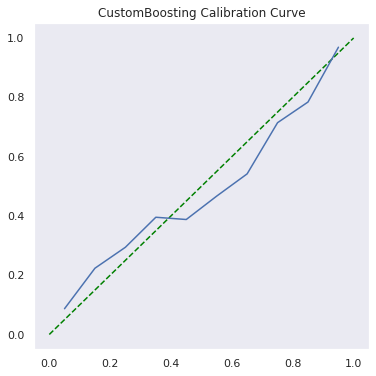

In [ ]:
plot_calibration_curve('CustomBoosting Calibration Curve', y_test, boost.predict_proba(x_test)[:,1])

In [ ]:
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=5,
    loss_function='Logloss',
    verbose=False)
catboost_classifier.fit(x_train, y_train)

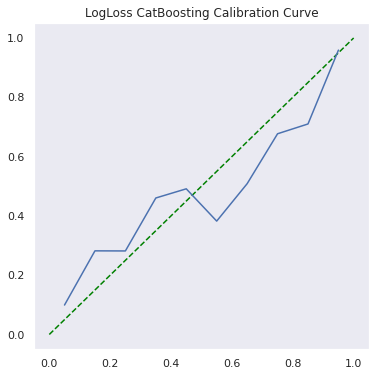

In [ ]:
plot_calibration_curve('LogLoss CatBoosting Calibration Curve', 
                       y_test, 
                       catboost_classifier.predict_proba(x_test)[:,1])

__Комментарий__ Бустинг хорошо оценивает вероятности, а наш так вообще замечательно!

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

<BarContainer object of 169 artists>

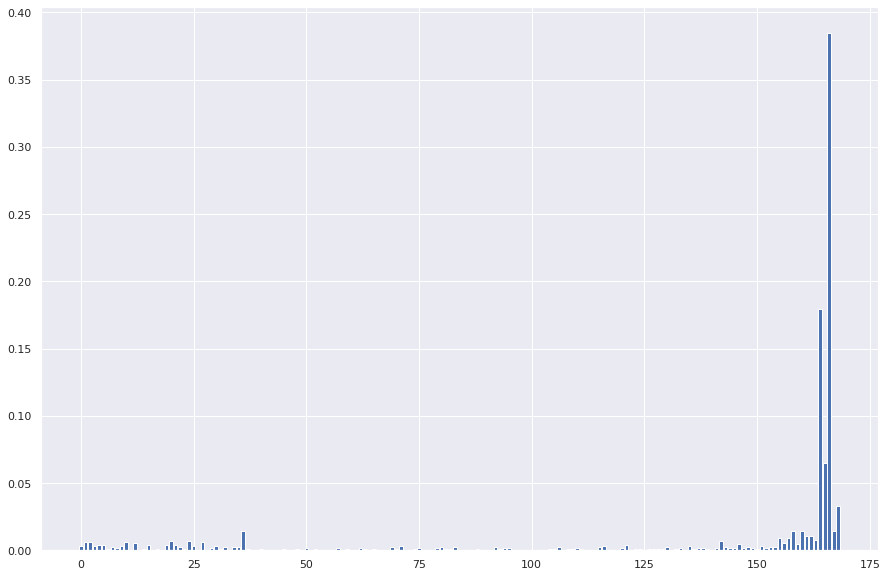

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(np.arange(boost.feature_importances_.shape[0]),
        boost.feature_importances_)

Полезная картинка..

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
qboost = Boosting(plot=False,
    base_model_params=param,
    n_estimators=n_estim,
    learning_rate=lr_best,
    subsample=sub_best)

q = np.quantile(boost.feature_importances_, 0.4)
features = boost.feature_importances_ > q

qboost.fit(x_train[:,features], y_train, x_valid[:,features], y_valid)

print('Train', qboost.score(x_train[:,features], y_train))
print('Test', qboost.score(x_test[:,features], y_test))

Train 0.9906310262857277
Test 0.9365914161508873
